In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_8321/2809884579.py:45: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


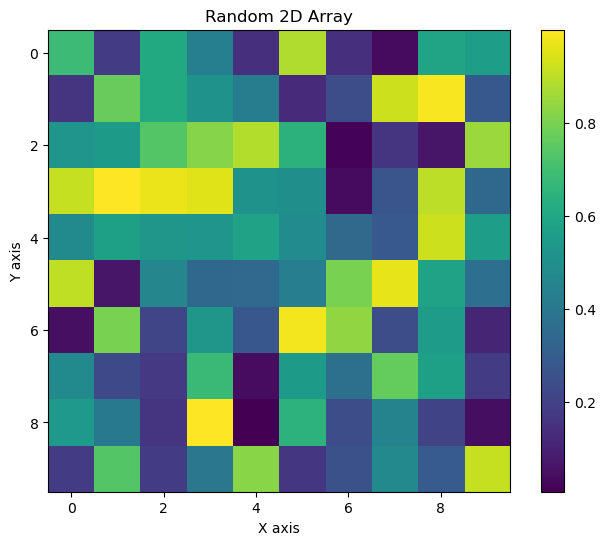

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
 # dvs 데이터 시각화 코드
 ##############################################################################################
            # mapping = {
            #     0: 'Hand Clapping',
            #     1: 'Right Hand Wave',
            #     2: 'Left Hand Wave',
            #     3: 'Right Arm CW',
            #     4: 'Right Arm CCW',
            #     5: 'Left Arm CW',
            #     6: 'Left Arm CCW',
            #     7: 'Arm Roll',
            #     8: 'Air Drums',
            #     9: 'Air Guitar',
            #     10: 'Other'
            # }
def dvs_visualization(inputs, labels, TIME, BATCH):
            
    what_input = random.randint(0, BATCH - 1)
    inputs_for_view = inputs.permute(1, 0, 2, 3, 4)
    for i in range(TIME):
        # 예시 데이터 생성
        data1 = inputs_for_view[what_input][i][0].numpy()  # torch tensor를 numpy 배열로 변환
        data2 = inputs_for_view[what_input][i][1].numpy()  # torch tensor를 numpy 배열로 변환

        # 데이터 플로팅
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1행 2열의 subplot 생성

        # 첫 번째 subplot에 데이터1 플로팅
        im1 = axs[0].imshow(data1, cmap='viridis', interpolation='nearest')
        axs[0].set_title(f'Channel 0\nLabel: {labels[what_input]}  Time: {i}')  # 라벨값 맵핑하여 제목에 추가
        axs[0].set_xlabel('X axis')
        axs[0].set_ylabel('Y axis')
        axs[0].grid(False)
        fig.colorbar(im1, ax=axs[0])  # Color bar 추가

        # 두 번째 subplot에 데이터2 플로팅
        im2 = axs[1].imshow(data2, cmap='viridis', interpolation='nearest')
        axs[1].set_title(f'Channel 1\nLabel: {labels[what_input]}  Time: {i}')  # 라벨값 맵핑하여 제목에 추가
        axs[1].set_xlabel('X axis')
        axs[1].set_ylabel('Y axis')
        axs[1].grid(False)
        fig.colorbar(im2, ax=axs[1])  # Color bar 추가

        plt.tight_layout()  # subplot 간 간격 조정
        plt.show()
    sys.exit("종료")

######################################################################################################

In [5]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = True, 
                    dvs_duration = 1000000,

                    OTTT_sWS_on = True, # True # False
                  ):
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False

    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    wandb.config.update(hyperparameters)
    wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
    wandb.define_metric("summary_val_acc", summary="max")
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    torch.manual_seed(my_seed)
    ###################################################################################################################################


    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                print('past_in_channel', past_in_channel)
                print('bias_param', bias_param)
                print('in_channel', in_channel)
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if pre_trained == False:
        if (convTrue_fcFalse == False):
            if (single_step == False):
                net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                            synapse_fc_trace_const1, synapse_fc_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on).to(device)
        else:
            if (single_step == False):
                net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                            synapse_conv_kernel_size, synapse_conv_stride, 
                            synapse_conv_padding, synapse_conv_trace_const1, 
                            synapse_conv_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on,
                            OTTT_sWS_on).to(device)
            else:
                net = MY_SNN_CONV_ottt_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                            synapse_conv_kernel_size, synapse_conv_stride, 
                            synapse_conv_padding, synapse_conv_trace_const1, 
                            synapse_conv_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on,
                            OTTT_sWS_on).to(device)
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net) #나중에풀어줘
    else:
        net = torch.load(pre_trained_path)

    net = net.to(device)
    if (net_print == True):
        print(net)        
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(iterator)):
            validation_interval2 = len(iterator)
        ##################################################################################################



        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            # print('inputs',inputs.size(),'\nlabels',labels.size())
                    
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                

                
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH)
            # ######################################################################################################


            ## device로 보내주기 ######################################
            real_batch = labels.size(0)
            ###########################################################


            ## gradient 초기화 #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            ###########################################################


            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)

            

            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter_acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)

                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                loss = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += loss.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)


                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    # torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                    # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                    # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                    # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            iterator.set_description(f"iter_acc: {iter_acc_string}, iter_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  
            wandb.log({"iter_acc": iter_acc}, step=i+epoch*len(train_loader))
            wandb.log({"tr_acc": tr_acc}, step=i+epoch*len(train_loader))
            wandb.log({"val_acc_now": val_acc_now}, step=i+epoch*len(train_loader))
            wandb.log({"summary_val_acc": val_acc_now})
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### 모듈 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # np.save(iter_acc_file_name_time, iter_acc_array)
            # np.save(tr_acc_file_name_time, iter_acc_array)
            # np.save(val_acc_file_name_time, val_acc_now_array)
            # with open(hyperparameters_file_name_time, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## 모듈 세이브 ###########################################################################################
            # np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
            # np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
            # np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
            # with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [6]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
wandb.init(project= f'my_snn {unique_name}')
my_snn_system(  devices = "2",
                single_step = True, # True # False
                unique_name = unique_name,
                my_seed = 42,
                TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'CIFAR10',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
                learning_rate = 0.1, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
                dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                #있는 데이터들 #gesture 1000000 #nmnist 10000

                OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


Files already downloaded and verified
Files already downloaded and verified
DataParallel(
  (module): MY_SNN_CONV_ottt_sstep(
    (layers): OTTTSequential(
      (0): SYNAPSE_CONV_trace_sstep()
      (1): LIF_layer_trace_sstep()
      (2): Scale()
      (3): SYNAPSE_CONV_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Scale()
      (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (7): SYNAPSE_CONV_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): Scale()
      (10): SYNAPSE_CONV_trace_sstep()
      (11): LIF_layer_trace_sstep()
      (12): Scale()
      (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (14): SYNAPSE_CONV_trace_sstep()
      (15): LIF_layer_trace_sstep()
      (16): Scale()
      (17): SYNAPSE_CONV_trace_sstep()
      (18): LIF_layer_trace_sstep()
      (19): Scale()
      (20): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (21): SYNAPSE_CONV_trace_sstep()
      (22): LIF_layer_trace_sstep()
      (23): Scale()
      (24): SYN

iter_acc: 0-390/391 iter_acc: 52.50%, lr=['0.1'], iter_loss: 0.21983318030834198, val_acc: 50.46%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]

epoch_time: 186.79969382286072 seconds

EPOCH 1



iter_acc: 1-390/391 iter_acc: 57.50%, lr=['0.09999725846827562'], iter_loss: 0.19812683761119843, val_acc: 60.60%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]

epoch_time: 179.86214804649353 seconds

EPOCH 2



iter_acc: 2-390/391 iter_acc: 63.75%, lr=['0.09998903417374229'], iter_loss: 0.14398472011089325, val_acc: 69.75%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 177.9391486644745 seconds

EPOCH 3



iter_acc: 3-390/391 iter_acc: 66.25%, lr=['0.0999753280182866'], iter_loss: 0.1151777133345604, val_acc: 73.55%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]

epoch_time: 183.47263288497925 seconds

EPOCH 4



iter_acc: 4-390/391 iter_acc: 77.50%, lr=['0.09995614150494293'], iter_loss: 0.11797098815441132, val_acc: 74.04%: 100%|██████████| 391/391 [03:09<00:00,  2.07it/s]

epoch_time: 189.22718834877014 seconds

EPOCH 5



iter_acc: 5-390/391 iter_acc: 77.50%, lr=['0.0999314767377287'], iter_loss: 0.13464386761188507, val_acc: 77.97%: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s]

epoch_time: 188.22753357887268 seconds

EPOCH 6



iter_acc: 6-390/391 iter_acc: 78.75%, lr=['0.09990133642141359'], iter_loss: 0.10266422480344772, val_acc: 79.43%: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]

epoch_time: 186.09957265853882 seconds

EPOCH 7



iter_acc: 7-390/391 iter_acc: 83.75%, lr=['0.0998657238612229'], iter_loss: 0.08485345542430878, val_acc: 81.45%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]

epoch_time: 186.65022468566895 seconds

EPOCH 8



iter_acc: 8-390/391 iter_acc: 75.00%, lr=['0.09982464296247523'], iter_loss: 0.09754413366317749, val_acc: 82.28%: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s]

epoch_time: 185.56348633766174 seconds

EPOCH 9



iter_acc: 9-390/391 iter_acc: 75.00%, lr=['0.099778098230154'], iter_loss: 0.08073090016841888, val_acc: 81.91%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]

epoch_time: 187.79250860214233 seconds

EPOCH 10



iter_acc: 10-390/391 iter_acc: 78.75%, lr=['0.09972609476841367'], iter_loss: 0.07601461559534073, val_acc: 84.13%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]

epoch_time: 184.24861407279968 seconds

EPOCH 11



iter_acc: 11-390/391 iter_acc: 86.25%, lr=['0.09966863828001983'], iter_loss: 0.07904863357543945, val_acc: 83.62%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s]

epoch_time: 189.99521136283875 seconds

EPOCH 12



iter_acc: 12-390/391 iter_acc: 83.75%, lr=['0.09960573506572391'], iter_loss: 0.09042832255363464, val_acc: 85.42%: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s]

epoch_time: 186.90590929985046 seconds

EPOCH 13



iter_acc: 13-390/391 iter_acc: 81.25%, lr=['0.09953739202357219'], iter_loss: 0.07250454276800156, val_acc: 86.61%: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s]

epoch_time: 182.87558245658875 seconds

EPOCH 14



iter_acc: 14-390/391 iter_acc: 83.75%, lr=['0.09946361664814943'], iter_loss: 0.09405820071697235, val_acc: 86.02%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.42890691757202 seconds

EPOCH 15



iter_acc: 15-390/391 iter_acc: 83.75%, lr=['0.0993844170297569'], iter_loss: 0.0586007796227932, val_acc: 86.70%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s] 

epoch_time: 180.4627890586853 seconds

EPOCH 16



iter_acc: 16-390/391 iter_acc: 82.50%, lr=['0.09929980185352526'], iter_loss: 0.10188736766576767, val_acc: 87.00%: 100%|██████████| 391/391 [03:10<00:00,  2.06it/s]

epoch_time: 190.2986936569214 seconds

EPOCH 17



iter_acc: 17-390/391 iter_acc: 90.00%, lr=['0.0992097803984621'], iter_loss: 0.06819678097963333, val_acc: 87.09%: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s]

epoch_time: 180.89619946479797 seconds

EPOCH 18



iter_acc: 18-390/391 iter_acc: 83.75%, lr=['0.09911436253643445'], iter_loss: 0.05594190955162048, val_acc: 88.09%: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s]

epoch_time: 182.66498637199402 seconds

EPOCH 19



iter_acc: 19-390/391 iter_acc: 87.50%, lr=['0.09901355873108611'], iter_loss: 0.07549135386943817, val_acc: 87.60%: 100%|██████████| 391/391 [03:03<00:00,  2.14it/s]

epoch_time: 183.34105801582336 seconds

EPOCH 20



iter_acc: 20-390/391 iter_acc: 88.75%, lr=['0.09890738003669029'], iter_loss: 0.07653224468231201, val_acc: 88.00%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]

epoch_time: 183.61269402503967 seconds

EPOCH 21



iter_acc: 21-390/391 iter_acc: 88.75%, lr=['0.09879583809693737'], iter_loss: 0.08398060500621796, val_acc: 87.84%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]

epoch_time: 184.51070499420166 seconds

EPOCH 22



iter_acc: 22-390/391 iter_acc: 92.50%, lr=['0.09867894514365802'], iter_loss: 0.05498407036066055, val_acc: 88.09%: 100%|██████████| 391/391 [02:55<00:00,  2.22it/s]

epoch_time: 175.92850613594055 seconds

EPOCH 23



iter_acc: 23-390/391 iter_acc: 90.00%, lr=['0.09855671399548181'], iter_loss: 0.11585753411054611, val_acc: 89.46%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]

epoch_time: 183.55969309806824 seconds

EPOCH 24



iter_acc: 24-390/391 iter_acc: 96.25%, lr=['0.09842915805643157'], iter_loss: 0.07352716475725174, val_acc: 89.30%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s]

epoch_time: 181.8733606338501 seconds

EPOCH 25



iter_acc: 25-390/391 iter_acc: 92.50%, lr=['0.09829629131445343'], iter_loss: 0.0650666132569313, val_acc: 89.41%: 100%|██████████| 391/391 [03:59<00:00,  1.63it/s] 

epoch_time: 240.03222584724426 seconds

EPOCH 26



iter_acc: 26-390/391 iter_acc: 97.50%, lr=['0.09815812833988292'], iter_loss: 0.11035826802253723, val_acc: 89.15%: 100%|██████████| 391/391 [04:26<00:00,  1.47it/s]

epoch_time: 266.4082021713257 seconds

EPOCH 27



iter_acc: 27-390/391 iter_acc: 91.25%, lr=['0.09801468428384717'], iter_loss: 0.0968332588672638, val_acc: 89.78%: 100%|██████████| 391/391 [04:23<00:00,  1.49it/s] 

epoch_time: 263.4714105129242 seconds

EPOCH 28



iter_acc: 28-390/391 iter_acc: 90.00%, lr=['0.09786597487660338'], iter_loss: 0.1360936313867569, val_acc: 88.95%: 100%|██████████| 391/391 [04:27<00:00,  1.46it/s] 

epoch_time: 268.09420347213745 seconds

EPOCH 29



iter_acc: 29-390/391 iter_acc: 93.75%, lr=['0.09771201642581387'], iter_loss: 0.08932002633810043, val_acc: 89.78%: 100%|██████████| 391/391 [04:14<00:00,  1.53it/s]

epoch_time: 255.10908842086792 seconds

EPOCH 30



iter_acc: 30-390/391 iter_acc: 92.50%, lr=['0.09755282581475772'], iter_loss: 0.07019299268722534, val_acc: 89.91%: 100%|██████████| 391/391 [04:05<00:00,  1.59it/s]

epoch_time: 245.5512716770172 seconds

EPOCH 31



iter_acc: 31-390/391 iter_acc: 92.50%, lr=['0.09738842050047931'], iter_loss: 0.0696248859167099, val_acc: 89.97%: 100%|██████████| 391/391 [04:49<00:00,  1.35it/s] 

epoch_time: 290.1440763473511 seconds

EPOCH 32



iter_acc: 32-390/391 iter_acc: 96.25%, lr=['0.09721881851187408'], iter_loss: 0.05756644904613495, val_acc: 90.66%: 100%|██████████| 391/391 [04:34<00:00,  1.42it/s]

epoch_time: 274.88340735435486 seconds

EPOCH 33



iter_acc: 33-390/391 iter_acc: 98.75%, lr=['0.0970440384477113'], iter_loss: 0.07053720206022263, val_acc: 90.67%: 100%|██████████| 391/391 [04:45<00:00,  1.37it/s]

epoch_time: 285.81780982017517 seconds

EPOCH 34



iter_acc: 34-390/391 iter_acc: 95.00%, lr=['0.0968640994745946'], iter_loss: 0.0767139196395874, val_acc: 90.36%: 100%|██████████| 391/391 [04:10<00:00,  1.56it/s] 

epoch_time: 250.18330717086792 seconds

EPOCH 35



iter_acc: 35-390/391 iter_acc: 91.25%, lr=['0.0966790213248601'], iter_loss: 0.07280676066875458, val_acc: 90.47%: 100%|██████████| 391/391 [04:04<00:00,  1.60it/s]

epoch_time: 244.57452654838562 seconds

EPOCH 36



iter_acc: 36-390/391 iter_acc: 90.00%, lr=['0.09648882429441259'], iter_loss: 0.07537270337343216, val_acc: 90.70%: 100%|██████████| 391/391 [04:13<00:00,  1.54it/s]

epoch_time: 253.86888694763184 seconds

EPOCH 37



iter_acc: 37-390/391 iter_acc: 97.50%, lr=['0.09629352924049978'], iter_loss: 0.07228220254182816, val_acc: 90.65%: 100%|██████████| 391/391 [04:01<00:00,  1.62it/s]

epoch_time: 242.00875234603882 seconds

EPOCH 38



iter_acc: 38-390/391 iter_acc: 93.75%, lr=['0.09609315757942506'], iter_loss: 0.05795593187212944, val_acc: 90.76%: 100%|██████████| 391/391 [04:33<00:00,  1.43it/s]

epoch_time: 273.4603452682495 seconds

EPOCH 39



iter_acc: 39-390/391 iter_acc: 97.50%, lr=['0.09588773128419908'], iter_loss: 0.0689907819032669, val_acc: 90.31%: 100%|██████████| 391/391 [04:25<00:00,  1.47it/s] 

epoch_time: 266.1317226886749 seconds

EPOCH 40



iter_acc: 40-390/391 iter_acc: 97.50%, lr=['0.09567727288213007'], iter_loss: 0.07373195886611938, val_acc: 91.08%: 100%|██████████| 391/391 [04:18<00:00,  1.51it/s]

epoch_time: 259.1409990787506 seconds

EPOCH 41



iter_acc: 41-390/391 iter_acc: 95.00%, lr=['0.09546180545235346'], iter_loss: 0.06563118100166321, val_acc: 91.47%: 100%|██████████| 391/391 [04:07<00:00,  1.58it/s]

epoch_time: 247.91387128829956 seconds

EPOCH 42



iter_acc: 42-390/391 iter_acc: 97.50%, lr=['0.09524135262330101'], iter_loss: 0.08198333531618118, val_acc: 91.02%: 100%|██████████| 391/391 [04:03<00:00,  1.61it/s] 

epoch_time: 243.2050862312317 seconds

EPOCH 43



iter_acc: 43-390/391 iter_acc: 90.00%, lr=['0.09501593857010972'], iter_loss: 0.045796677470207214, val_acc: 91.10%: 100%|██████████| 391/391 [04:07<00:00,  1.58it/s]

epoch_time: 247.28993201255798 seconds

EPOCH 44



iter_acc: 44-390/391 iter_acc: 97.50%, lr=['0.09478558801197068'], iter_loss: 0.07334693521261215, val_acc: 91.30%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]

epoch_time: 179.10973238945007 seconds

EPOCH 45



iter_acc: 45-390/391 iter_acc: 95.00%, lr=['0.09455032620941842'], iter_loss: 0.07827743142843246, val_acc: 91.45%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s]

epoch_time: 190.1740219593048 seconds

EPOCH 46



iter_acc: 46-390/391 iter_acc: 97.50%, lr=['0.09431017896156076'], iter_loss: 0.06969204545021057, val_acc: 90.90%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]

epoch_time: 197.0273082256317 seconds

EPOCH 47



iter_acc: 47-390/391 iter_acc: 97.50%, lr=['0.09406517260324962'], iter_loss: 0.06783393025398254, val_acc: 91.63%: 100%|██████████| 391/391 [03:30<00:00,  1.85it/s]

epoch_time: 211.10242581367493 seconds

EPOCH 48



iter_acc: 48-390/391 iter_acc: 96.25%, lr=['0.09381533400219319'], iter_loss: 0.07515931129455566, val_acc: 90.84%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s] 

epoch_time: 190.9898226261139 seconds

EPOCH 49



iter_acc: 49-390/391 iter_acc: 97.50%, lr=['0.09356069055600949'], iter_loss: 0.09008507430553436, val_acc: 91.14%: 100%|██████████| 391/391 [03:29<00:00,  1.87it/s] 

epoch_time: 209.26180338859558 seconds

EPOCH 50



iter_acc: 50-390/391 iter_acc: 96.25%, lr=['0.09330127018922195'], iter_loss: 0.09113170206546783, val_acc: 91.57%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.21781492233276 seconds

EPOCH 51



iter_acc: 51-390/391 iter_acc: 98.75%, lr=['0.0930371013501972'], iter_loss: 0.09315484762191772, val_acc: 91.30%: 100%|██████████| 391/391 [03:34<00:00,  1.83it/s] 

epoch_time: 214.21790146827698 seconds

EPOCH 52



iter_acc: 52-390/391 iter_acc: 92.50%, lr=['0.09276821300802535'], iter_loss: 0.07455512136220932, val_acc: 91.55%: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s] 

epoch_time: 203.9627342224121 seconds

EPOCH 53



iter_acc: 53-390/391 iter_acc: 98.75%, lr=['0.09249463464934321'], iter_loss: 0.08551381528377533, val_acc: 91.58%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s] 

epoch_time: 187.674476146698 seconds

EPOCH 54



iter_acc: 54-390/391 iter_acc: 98.75%, lr=['0.09221639627510077'], iter_loss: 0.07874483615159988, val_acc: 91.55%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s] 

epoch_time: 202.6011347770691 seconds

EPOCH 55



iter_acc: 55-390/391 iter_acc: 97.50%, lr=['0.09193352839727122'], iter_loss: 0.0693407654762268, val_acc: 92.00%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s]  

epoch_time: 180.59844589233398 seconds

EPOCH 56



iter_acc: 56-390/391 iter_acc: 97.50%, lr=['0.09164606203550499'], iter_loss: 0.06659053266048431, val_acc: 91.67%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s] 

epoch_time: 201.28884625434875 seconds

EPOCH 57



iter_acc: 57-390/391 iter_acc: 97.50%, lr=['0.0913540287137281'], iter_loss: 0.08170193433761597, val_acc: 91.47%: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s] 

epoch_time: 182.7330777645111 seconds

EPOCH 58



iter_acc: 58-390/391 iter_acc: 97.50%, lr=['0.09105746045668521'], iter_loss: 0.07273052632808685, val_acc: 91.78%: 100%|██████████| 391/391 [03:27<00:00,  1.88it/s] 

epoch_time: 207.79045581817627 seconds

EPOCH 59



iter_acc: 59-390/391 iter_acc: 98.75%, lr=['0.09075638978642771'], iter_loss: 0.042938411235809326, val_acc: 91.70%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s]

epoch_time: 204.70860838890076 seconds

EPOCH 60



iter_acc: 60-390/391 iter_acc: 96.25%, lr=['0.09045084971874738'], iter_loss: 0.05988059937953949, val_acc: 91.85%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s] 

epoch_time: 176.66552734375 seconds

EPOCH 61



iter_acc: 61-390/391 iter_acc: 96.25%, lr=['0.09014087375955573'], iter_loss: 0.09032443165779114, val_acc: 91.65%: 100%|██████████| 391/391 [02:59<00:00,  2.17it/s] 

epoch_time: 180.17144012451172 seconds

EPOCH 62



iter_acc: 62-390/391 iter_acc: 97.50%, lr=['0.08982649590120982'], iter_loss: 0.07800906896591187, val_acc: 91.75%: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s] 

epoch_time: 185.87698817253113 seconds

EPOCH 63



iter_acc: 63-390/391 iter_acc: 96.25%, lr=['0.08950775061878452'], iter_loss: 0.08473827689886093, val_acc: 92.04%: 100%|██████████| 391/391 [03:53<00:00,  1.68it/s] 

epoch_time: 233.506826877594 seconds

EPOCH 64



iter_acc: 64-390/391 iter_acc: 98.75%, lr=['0.089184672866292'], iter_loss: 0.06561294198036194, val_acc: 92.00%: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]

epoch_time: 213.96638345718384 seconds

EPOCH 65



iter_acc: 65-390/391 iter_acc: 95.00%, lr=['0.08885729807284856'], iter_loss: 0.06125485897064209, val_acc: 91.64%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s] 

epoch_time: 177.50676488876343 seconds

EPOCH 66



iter_acc: 66-390/391 iter_acc: 100.00%, lr=['0.08852566213878947'], iter_loss: 0.08262740075588226, val_acc: 91.67%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]

epoch_time: 194.7998719215393 seconds

EPOCH 67



iter_acc: 67-390/391 iter_acc: 96.25%, lr=['0.08818980143173213'], iter_loss: 0.05341711640357971, val_acc: 92.04%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s] 

epoch_time: 187.26699090003967 seconds

EPOCH 68



iter_acc: 68-390/391 iter_acc: 96.25%, lr=['0.08784975278258783'], iter_loss: 0.061360668390989304, val_acc: 91.74%: 100%|██████████| 391/391 [04:05<00:00,  1.60it/s]

epoch_time: 245.3001790046692 seconds

EPOCH 69



iter_acc: 69-390/391 iter_acc: 98.75%, lr=['0.08750555348152299'], iter_loss: 0.06053036078810692, val_acc: 92.29%: 100%|██████████| 391/391 [03:53<00:00,  1.67it/s] 

epoch_time: 234.03155827522278 seconds

EPOCH 70



iter_acc: 70-390/391 iter_acc: 98.75%, lr=['0.08715724127386973'], iter_loss: 0.07410945743322372, val_acc: 91.97%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s] 

epoch_time: 179.42003440856934 seconds

EPOCH 71



iter_acc: 71-390/391 iter_acc: 97.50%, lr=['0.08680485435598673'], iter_loss: 0.08101749420166016, val_acc: 91.50%: 100%|██████████| 391/391 [04:10<00:00,  1.56it/s] 

epoch_time: 250.30630207061768 seconds

EPOCH 72



iter_acc: 72-390/391 iter_acc: 96.25%, lr=['0.0864484313710706'], iter_loss: 0.0700424537062645, val_acc: 92.04%: 100%|██████████| 391/391 [04:06<00:00,  1.59it/s]  

epoch_time: 246.7883415222168 seconds

EPOCH 73



iter_acc: 73-390/391 iter_acc: 95.00%, lr=['0.08608801140491813'], iter_loss: 0.05126051604747772, val_acc: 91.84%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s] 

epoch_time: 181.96234822273254 seconds

EPOCH 74



iter_acc: 74-390/391 iter_acc: 97.50%, lr=['0.0857236339816402'], iter_loss: 0.0554540678858757, val_acc: 92.16%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]  

epoch_time: 177.54482746124268 seconds

EPOCH 75



iter_acc: 75-390/391 iter_acc: 95.00%, lr=['0.0853553390593274'], iter_loss: 0.08429455757141113, val_acc: 91.90%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s] 

epoch_time: 184.5422236919403 seconds

EPOCH 76



iter_acc: 76-390/391 iter_acc: 95.00%, lr=['0.08498316702566831'], iter_loss: 0.059028707444667816, val_acc: 91.83%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]

epoch_time: 193.34610056877136 seconds

EPOCH 77



iter_acc: 77-390/391 iter_acc: 97.50%, lr=['0.08460715869352037'], iter_loss: 0.09316088259220123, val_acc: 92.10%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s] 

epoch_time: 179.44090008735657 seconds

EPOCH 78



iter_acc: 78-390/391 iter_acc: 96.25%, lr=['0.08422735529643446'], iter_loss: 0.08217059075832367, val_acc: 91.92%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s] 

epoch_time: 183.85005593299866 seconds

EPOCH 79



iter_acc: 79-390/391 iter_acc: 97.50%, lr=['0.08384379848413306'], iter_loss: 0.06613031029701233, val_acc: 92.08%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s] 

epoch_time: 180.58957386016846 seconds

EPOCH 80



iter_acc: 80-390/391 iter_acc: 98.75%, lr=['0.08345653031794294'], iter_loss: 0.0633472353219986, val_acc: 92.01%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s]  

epoch_time: 180.67837619781494 seconds

EPOCH 81



iter_acc: 81-390/391 iter_acc: 98.75%, lr=['0.08306559326618262'], iter_loss: 0.06705271452665329, val_acc: 92.48%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s] 

epoch_time: 187.59840965270996 seconds

EPOCH 82



iter_acc: 82-390/391 iter_acc: 96.25%, lr=['0.08267103019950531'], iter_loss: 0.09225263446569443, val_acc: 92.16%: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s] 

epoch_time: 187.15315914154053 seconds

EPOCH 83



iter_acc: 83-390/391 iter_acc: 98.75%, lr=['0.08227288438619755'], iter_loss: 0.1145591139793396, val_acc: 92.08%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s]  

epoch_time: 180.36896109580994 seconds

EPOCH 84



iter_acc: 84-390/391 iter_acc: 97.50%, lr=['0.0818711994874345'], iter_loss: 0.06754499673843384, val_acc: 91.79%: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s] 

epoch_time: 185.4943253993988 seconds

EPOCH 85



iter_acc: 85-390/391 iter_acc: 97.50%, lr=['0.08146601955249189'], iter_loss: 0.06023787707090378, val_acc: 91.41%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s] 

epoch_time: 183.87380003929138 seconds

EPOCH 86



iter_acc: 86-390/391 iter_acc: 97.50%, lr=['0.08105738901391554'], iter_loss: 0.08711182326078415, val_acc: 91.61%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s] 

epoch_time: 187.43342232704163 seconds

EPOCH 87



iter_acc: 87-390/391 iter_acc: 98.75%, lr=['0.08064535268264884'], iter_loss: 0.06941714882850647, val_acc: 92.47%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.51277661323547 seconds

EPOCH 88



iter_acc: 88-390/391 iter_acc: 98.75%, lr=['0.08022995574311877'], iter_loss: 0.1119183897972107, val_acc: 92.32%: 100%|██████████| 391/391 [04:11<00:00,  1.55it/s]  

epoch_time: 252.0534040927887 seconds

EPOCH 89



iter_acc: 89-390/391 iter_acc: 100.00%, lr=['0.0798112437482808'], iter_loss: 0.07540211081504822, val_acc: 92.47%: 100%|██████████| 391/391 [04:33<00:00,  1.43it/s]

epoch_time: 273.5252182483673 seconds

EPOCH 90



iter_acc: 90-390/391 iter_acc: 97.50%, lr=['0.07938926261462366'], iter_loss: 0.08927755802869797, val_acc: 92.28%: 100%|██████████| 391/391 [03:54<00:00,  1.67it/s] 

epoch_time: 234.67382502555847 seconds

EPOCH 91



iter_acc: 91-390/391 iter_acc: 97.50%, lr=['0.07896405861713394'], iter_loss: 0.07102488726377487, val_acc: 92.18%: 100%|██████████| 391/391 [04:26<00:00,  1.47it/s] 

epoch_time: 266.5257902145386 seconds

EPOCH 92



iter_acc: 92-390/391 iter_acc: 97.50%, lr=['0.0785356783842216'], iter_loss: 0.07878366112709045, val_acc: 92.28%: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s] 

epoch_time: 244.11662411689758 seconds

EPOCH 93



iter_acc: 93-390/391 iter_acc: 97.50%, lr=['0.07810416889260655'], iter_loss: 0.07932424545288086, val_acc: 92.29%: 100%|██████████| 391/391 [04:51<00:00,  1.34it/s] 

epoch_time: 291.2846224308014 seconds

EPOCH 94



iter_acc: 94-390/391 iter_acc: 95.00%, lr=['0.07766957746216721'], iter_loss: 0.07182221114635468, val_acc: 92.34%: 100%|██████████| 391/391 [04:14<00:00,  1.54it/s] 

epoch_time: 254.34973311424255 seconds

EPOCH 95



iter_acc: 95-390/391 iter_acc: 98.75%, lr=['0.07723195175075136'], iter_loss: 0.10332825779914856, val_acc: 92.28%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s] 

epoch_time: 252.58239078521729 seconds

EPOCH 96



iter_acc: 96-390/391 iter_acc: 98.75%, lr=['0.07679133974894983'], iter_loss: 0.08929618448019028, val_acc: 92.26%: 100%|██████████| 391/391 [04:14<00:00,  1.54it/s] 

epoch_time: 254.25552201271057 seconds

EPOCH 97



iter_acc: 97-390/391 iter_acc: 98.75%, lr=['0.07634778977483389'], iter_loss: 0.0833638608455658, val_acc: 92.24%: 100%|██████████| 391/391 [04:22<00:00,  1.49it/s]  

epoch_time: 262.643816947937 seconds

EPOCH 98



iter_acc: 98-390/391 iter_acc: 100.00%, lr=['0.07590135046865652'], iter_loss: 0.0712921991944313, val_acc: 91.85%: 100%|██████████| 391/391 [04:27<00:00,  1.46it/s] 

epoch_time: 267.5885577201843 seconds

EPOCH 99



iter_acc: 99-390/391 iter_acc: 98.75%, lr=['0.07545207078751857'], iter_loss: 0.08044856786727905, val_acc: 92.44%: 100%|██████████| 391/391 [04:17<00:00,  1.52it/s] 

epoch_time: 258.0053324699402 seconds

EPOCH 100



iter_acc: 100-390/391 iter_acc: 98.75%, lr=['0.07500000000000001'], iter_loss: 0.07751333713531494, val_acc: 92.44%: 100%|██████████| 391/391 [04:18<00:00,  1.51it/s] 

epoch_time: 258.8494565486908 seconds

EPOCH 101



iter_acc: 101-390/391 iter_acc: 100.00%, lr=['0.07454518768075706'], iter_loss: 0.07345302402973175, val_acc: 92.63%: 100%|██████████| 391/391 [04:07<00:00,  1.58it/s]

epoch_time: 248.01539969444275 seconds

EPOCH 102



iter_acc: 102-390/391 iter_acc: 98.75%, lr=['0.07408768370508578'], iter_loss: 0.055220555514097214, val_acc: 92.24%: 100%|██████████| 391/391 [03:51<00:00,  1.69it/s]

epoch_time: 231.81821250915527 seconds

EPOCH 103



iter_acc: 103-390/391 iter_acc: 98.75%, lr=['0.07362753824345272'], iter_loss: 0.05969150364398956, val_acc: 92.61%: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s] 

epoch_time: 279.9462513923645 seconds

EPOCH 104



iter_acc: 104-390/391 iter_acc: 100.00%, lr=['0.07316480175599312'], iter_loss: 0.08834006637334824, val_acc: 92.33%: 100%|██████████| 391/391 [04:11<00:00,  1.55it/s]

epoch_time: 252.1432433128357 seconds

EPOCH 105



iter_acc: 105-390/391 iter_acc: 97.50%, lr=['0.07269952498697736'], iter_loss: 0.07467086613178253, val_acc: 92.43%: 100%|██████████| 391/391 [04:20<00:00,  1.50it/s] 

epoch_time: 260.3488314151764 seconds

EPOCH 106



iter_acc: 106-390/391 iter_acc: 98.75%, lr=['0.0722317589592464'], iter_loss: 0.08939792215824127, val_acc: 92.53%: 100%|██████████| 391/391 [04:11<00:00,  1.55it/s] 

epoch_time: 252.17112278938293 seconds

EPOCH 107



iter_acc: 107-390/391 iter_acc: 96.25%, lr=['0.0717615549686164'], iter_loss: 0.06830070912837982, val_acc: 92.87%: 100%|██████████| 391/391 [04:32<00:00,  1.44it/s] 

epoch_time: 272.4378967285156 seconds

EPOCH 108



iter_acc: 108-390/391 iter_acc: 98.75%, lr=['0.07128896457825365'], iter_loss: 0.06745336204767227, val_acc: 92.34%: 100%|██████████| 391/391 [04:28<00:00,  1.46it/s] 

epoch_time: 268.30302929878235 seconds

EPOCH 109



iter_acc: 109-390/391 iter_acc: 97.50%, lr=['0.07081403961302007'], iter_loss: 0.07728594541549683, val_acc: 92.45%: 100%|██████████| 391/391 [04:16<00:00,  1.53it/s] 

epoch_time: 256.4623804092407 seconds

EPOCH 110



iter_acc: 110-390/391 iter_acc: 96.25%, lr=['0.07033683215379001'], iter_loss: 0.07393614202737808, val_acc: 92.69%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s] 

epoch_time: 252.6146101951599 seconds

EPOCH 111



iter_acc: 111-390/391 iter_acc: 97.50%, lr=['0.06985739453173903'], iter_loss: 0.09491780400276184, val_acc: 92.15%: 100%|██████████| 391/391 [04:10<00:00,  1.56it/s] 

epoch_time: 250.43456268310547 seconds

EPOCH 112



iter_acc: 112-390/391 iter_acc: 100.00%, lr=['0.06937577932260515'], iter_loss: 0.07412077486515045, val_acc: 92.39%: 100%|██████████| 391/391 [03:56<00:00,  1.66it/s]

epoch_time: 236.43649315834045 seconds

EPOCH 113



iter_acc: 113-390/391 iter_acc: 97.50%, lr=['0.06889203934092336'], iter_loss: 0.10090040415525436, val_acc: 92.68%: 100%|██████████| 391/391 [04:35<00:00,  1.42it/s] 

epoch_time: 276.02086901664734 seconds

EPOCH 114



iter_acc: 114-390/391 iter_acc: 100.00%, lr=['0.0684062276342339'], iter_loss: 0.06549309939146042, val_acc: 92.56%: 100%|██████████| 391/391 [04:07<00:00,  1.58it/s]

epoch_time: 247.69844913482666 seconds

EPOCH 115



iter_acc: 115-390/391 iter_acc: 100.00%, lr=['0.067918397477265'], iter_loss: 0.07264439761638641, val_acc: 92.33%: 100%|██████████| 391/391 [04:30<00:00,  1.44it/s]

epoch_time: 270.798054933548 seconds

EPOCH 116



iter_acc: 116-390/391 iter_acc: 97.50%, lr=['0.06742860236609076'], iter_loss: 0.1033368706703186, val_acc: 92.40%: 100%|██████████| 391/391 [04:19<00:00,  1.50it/s]  

epoch_time: 260.07695484161377 seconds

EPOCH 117



iter_acc: 117-390/391 iter_acc: 97.50%, lr=['0.06693689601226457'], iter_loss: 0.08488591760396957, val_acc: 92.58%: 100%|██████████| 391/391 [04:15<00:00,  1.53it/s] 

epoch_time: 255.58939695358276 seconds

EPOCH 118



iter_acc: 118-390/391 iter_acc: 98.75%, lr=['0.06644333233692916'], iter_loss: 0.10060830414295197, val_acc: 92.11%: 100%|██████████| 391/391 [04:40<00:00,  1.39it/s] 

epoch_time: 280.58066964149475 seconds

EPOCH 119



iter_acc: 119-390/391 iter_acc: 98.75%, lr=['0.0659479654649035'], iter_loss: 0.10232686996459961, val_acc: 92.70%: 100%|██████████| 391/391 [04:13<00:00,  1.54it/s] 

epoch_time: 253.3075499534607 seconds

EPOCH 120



iter_acc: 120-390/391 iter_acc: 96.25%, lr=['0.06545084971874737'], iter_loss: 0.06893646717071533, val_acc: 92.40%: 100%|██████████| 391/391 [04:33<00:00,  1.43it/s] 

epoch_time: 273.3620889186859 seconds

EPOCH 121



iter_acc: 121-390/391 iter_acc: 100.00%, lr=['0.06495203961280434'], iter_loss: 0.09193116426467896, val_acc: 92.62%: 100%|██████████| 391/391 [04:38<00:00,  1.41it/s]

epoch_time: 278.29274725914 seconds

EPOCH 122



iter_acc: 122-390/391 iter_acc: 98.75%, lr=['0.06445158984722359'], iter_loss: 0.07458451390266418, val_acc: 92.53%: 100%|██████████| 391/391 [04:19<00:00,  1.50it/s] 

epoch_time: 260.17129731178284 seconds

EPOCH 123



iter_acc: 123-390/391 iter_acc: 98.75%, lr=['0.06394955530196147'], iter_loss: 0.08461868762969971, val_acc: 92.69%: 100%|██████████| 391/391 [04:23<00:00,  1.48it/s] 

epoch_time: 263.5705637931824 seconds

EPOCH 124



iter_acc: 124-390/391 iter_acc: 98.75%, lr=['0.06344599103076329'], iter_loss: 0.0706375241279602, val_acc: 92.63%: 100%|██████████| 391/391 [04:10<00:00,  1.56it/s]  

epoch_time: 250.73638439178467 seconds

EPOCH 125



iter_acc: 125-390/391 iter_acc: 100.00%, lr=['0.06294095225512605'], iter_loss: 0.09624263644218445, val_acc: 92.65%: 100%|██████████| 391/391 [04:25<00:00,  1.48it/s]

epoch_time: 265.3312313556671 seconds

EPOCH 126



iter_acc: 126-390/391 iter_acc: 100.00%, lr=['0.062434494358242734'], iter_loss: 0.08985282480716705, val_acc: 92.47%: 100%|██████████| 391/391 [04:34<00:00,  1.43it/s]

epoch_time: 274.217787027359 seconds

EPOCH 127



iter_acc: 127-390/391 iter_acc: 97.50%, lr=['0.06192667287892904'], iter_loss: 0.0789058730006218, val_acc: 92.59%: 100%|██████████| 391/391 [03:59<00:00,  1.63it/s]  

epoch_time: 240.1129789352417 seconds

EPOCH 128



iter_acc: 128-390/391 iter_acc: 97.50%, lr=['0.06141754350553279'], iter_loss: 0.07402485609054565, val_acc: 92.77%: 100%|██████████| 391/391 [03:48<00:00,  1.71it/s] 

epoch_time: 228.29881834983826 seconds

EPOCH 129



iter_acc: 129-390/391 iter_acc: 98.75%, lr=['0.06090716206982714'], iter_loss: 0.09910605847835541, val_acc: 92.62%: 100%|██████████| 391/391 [04:01<00:00,  1.62it/s] 

epoch_time: 241.61908268928528 seconds

EPOCH 130



iter_acc: 130-390/391 iter_acc: 98.75%, lr=['0.06039558454088797'], iter_loss: 0.1042306050658226, val_acc: 92.65%: 100%|██████████| 391/391 [04:40<00:00,  1.39it/s]  

epoch_time: 280.66414165496826 seconds

EPOCH 131



iter_acc: 131-390/391 iter_acc: 98.75%, lr=['0.059882867018956294'], iter_loss: 0.08142891526222229, val_acc: 92.68%: 100%|██████████| 391/391 [04:14<00:00,  1.53it/s] 

epoch_time: 255.03560423851013 seconds

EPOCH 132



iter_acc: 132-390/391 iter_acc: 98.75%, lr=['0.05936906572928624'], iter_loss: 0.07865332812070847, val_acc: 92.77%: 100%|██████████| 391/391 [04:15<00:00,  1.53it/s] 

epoch_time: 255.7626097202301 seconds

EPOCH 133



iter_acc: 133-390/391 iter_acc: 97.50%, lr=['0.05885423701597917'], iter_loss: 0.08322731405496597, val_acc: 92.69%: 100%|██████████| 391/391 [04:21<00:00,  1.49it/s] 

epoch_time: 262.0455152988434 seconds

EPOCH 134



iter_acc: 134-390/391 iter_acc: 100.00%, lr=['0.05833843733580512'], iter_loss: 0.11314602941274643, val_acc: 92.47%: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]

epoch_time: 279.3017044067383 seconds

EPOCH 135



iter_acc: 135-390/391 iter_acc: 98.75%, lr=['0.057821723252011556'], iter_loss: 0.08544354885816574, val_acc: 92.46%: 100%|██████████| 391/391 [04:07<00:00,  1.58it/s] 

epoch_time: 247.54242253303528 seconds

EPOCH 136



iter_acc: 136-390/391 iter_acc: 98.75%, lr=['0.0573041514281206'], iter_loss: 0.08439233899116516, val_acc: 92.78%: 100%|██████████| 391/391 [04:18<00:00,  1.51it/s] 

epoch_time: 258.3416771888733 seconds

EPOCH 137



iter_acc: 137-390/391 iter_acc: 98.75%, lr=['0.05678577862171523'], iter_loss: 0.10631586611270905, val_acc: 92.75%: 100%|██████████| 391/391 [04:19<00:00,  1.51it/s] 

epoch_time: 259.5134069919586 seconds

EPOCH 138



iter_acc: 138-390/391 iter_acc: 98.75%, lr=['0.05626666167821522'], iter_loss: 0.09608618915081024, val_acc: 92.84%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s] 

epoch_time: 253.12192010879517 seconds

EPOCH 139



iter_acc: 139-390/391 iter_acc: 97.50%, lr=['0.055746857524643346'], iter_loss: 0.1114392802119255, val_acc: 92.78%: 100%|██████████| 391/391 [04:28<00:00,  1.45it/s]  

epoch_time: 269.026451587677 seconds

EPOCH 140



iter_acc: 140-390/391 iter_acc: 98.75%, lr=['0.0552264231633827'], iter_loss: 0.08378313481807709, val_acc: 92.86%: 100%|██████████| 391/391 [04:25<00:00,  1.47it/s] 

epoch_time: 266.09142780303955 seconds

EPOCH 141



iter_acc: 141-390/391 iter_acc: 97.50%, lr=['0.05470541566592574'], iter_loss: 0.09725351631641388, val_acc: 92.70%: 100%|██████████| 391/391 [04:15<00:00,  1.53it/s] 

epoch_time: 255.3283543586731 seconds

EPOCH 142



iter_acc: 142-390/391 iter_acc: 100.00%, lr=['0.05418389216661579'], iter_loss: 0.11248864978551865, val_acc: 92.63%: 100%|██████████| 391/391 [04:01<00:00,  1.62it/s]

epoch_time: 241.87876629829407 seconds

EPOCH 143



iter_acc: 143-390/391 iter_acc: 98.75%, lr=['0.0536619098563816'], iter_loss: 0.09595304727554321, val_acc: 92.75%: 100%|██████████| 391/391 [04:27<00:00,  1.46it/s] 

epoch_time: 267.33870482444763 seconds

EPOCH 144



iter_acc: 144-390/391 iter_acc: 97.50%, lr=['0.053139525976465686'], iter_loss: 0.08008161187171936, val_acc: 92.64%: 100%|██████████| 391/391 [04:18<00:00,  1.51it/s] 

epoch_time: 259.1180934906006 seconds

EPOCH 145



iter_acc: 145-390/391 iter_acc: 95.00%, lr=['0.05261679781214721'], iter_loss: 0.0754099041223526, val_acc: 92.86%: 100%|██████████| 391/391 [04:19<00:00,  1.51it/s]  

epoch_time: 260.05239391326904 seconds

EPOCH 146



iter_acc: 146-390/391 iter_acc: 100.00%, lr=['0.05209378268646'], iter_loss: 0.08918599784374237, val_acc: 92.70%: 100%|██████████| 391/391 [04:23<00:00,  1.49it/s]

epoch_time: 263.3735566139221 seconds

EPOCH 147



iter_acc: 147-390/391 iter_acc: 98.75%, lr=['0.05157053795390641'], iter_loss: 0.09479072690010071, val_acc: 92.89%: 100%|██████████| 391/391 [04:26<00:00,  1.47it/s] 

epoch_time: 266.964528799057 seconds

EPOCH 148



iter_acc: 148-390/391 iter_acc: 100.00%, lr=['0.051047120994167854'], iter_loss: 0.08645766973495483, val_acc: 92.89%: 100%|██████████| 391/391 [04:41<00:00,  1.39it/s]

epoch_time: 281.9355573654175 seconds

EPOCH 149



iter_acc: 149-390/391 iter_acc: 100.00%, lr=['0.0505235892058123'], iter_loss: 0.1122414767742157, val_acc: 92.78%: 100%|██████████| 391/391 [04:11<00:00,  1.56it/s] 

epoch_time: 251.44574213027954 seconds

EPOCH 150



iter_acc: 150-390/391 iter_acc: 100.00%, lr=['0.05000000000000001'], iter_loss: 0.09022367000579834, val_acc: 92.75%: 100%|██████████| 391/391 [04:47<00:00,  1.36it/s]

epoch_time: 288.20490026474 seconds

EPOCH 151



iter_acc: 151-390/391 iter_acc: 100.00%, lr=['0.04947641079418772'], iter_loss: 0.07223299145698547, val_acc: 92.77%: 100%|██████████| 391/391 [04:45<00:00,  1.37it/s]

epoch_time: 285.9659950733185 seconds

EPOCH 152



iter_acc: 152-390/391 iter_acc: 100.00%, lr=['0.04895287900583217'], iter_loss: 0.07905957102775574, val_acc: 92.81%: 100%|██████████| 391/391 [03:58<00:00,  1.64it/s]

epoch_time: 238.95153284072876 seconds

EPOCH 153



iter_acc: 153-390/391 iter_acc: 98.75%, lr=['0.048429462046093594'], iter_loss: 0.06966119259595871, val_acc: 92.67%: 100%|██████████| 391/391 [04:25<00:00,  1.47it/s] 

epoch_time: 265.58908796310425 seconds

EPOCH 154



iter_acc: 154-390/391 iter_acc: 100.00%, lr=['0.04790621731354002'], iter_loss: 0.07444523274898529, val_acc: 92.85%: 100%|██████████| 391/391 [04:24<00:00,  1.48it/s]

epoch_time: 264.91331362724304 seconds

EPOCH 155



iter_acc: 155-390/391 iter_acc: 100.00%, lr=['0.04738320218785281'], iter_loss: 0.09076686203479767, val_acc: 92.90%: 100%|██████████| 391/391 [04:35<00:00,  1.42it/s]

epoch_time: 276.071013212204 seconds

EPOCH 156



iter_acc: 156-390/391 iter_acc: 96.25%, lr=['0.04686047402353434'], iter_loss: 0.07566015422344208, val_acc: 92.62%: 100%|██████████| 391/391 [04:28<00:00,  1.46it/s] 

epoch_time: 268.36383175849915 seconds

EPOCH 157



iter_acc: 157-390/391 iter_acc: 100.00%, lr=['0.04633809014361842'], iter_loss: 0.06956291198730469, val_acc: 92.85%: 100%|██████████| 391/391 [04:09<00:00,  1.57it/s]

epoch_time: 249.7422707080841 seconds

EPOCH 158



iter_acc: 158-390/391 iter_acc: 96.25%, lr=['0.04581610783338422'], iter_loss: 0.06733878701925278, val_acc: 92.91%: 100%|██████████| 391/391 [04:06<00:00,  1.59it/s] 

epoch_time: 246.50171780586243 seconds

EPOCH 159



iter_acc: 159-390/391 iter_acc: 98.75%, lr=['0.045294584334074274'], iter_loss: 0.09249924123287201, val_acc: 92.74%: 100%|██████████| 391/391 [04:24<00:00,  1.48it/s] 

epoch_time: 264.2065842151642 seconds

EPOCH 160



iter_acc: 160-390/391 iter_acc: 97.50%, lr=['0.044773576836617326'], iter_loss: 0.06197522580623627, val_acc: 92.76%: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s] 

epoch_time: 243.98525667190552 seconds

EPOCH 161



iter_acc: 161-390/391 iter_acc: 95.00%, lr=['0.044253142475356666'], iter_loss: 0.08440558612346649, val_acc: 92.77%: 100%|██████████| 391/391 [04:26<00:00,  1.47it/s] 

epoch_time: 266.75288343429565 seconds

EPOCH 162



iter_acc: 162-390/391 iter_acc: 97.50%, lr=['0.04373333832178478'], iter_loss: 0.09549950808286667, val_acc: 93.01%: 100%|██████████| 391/391 [03:56<00:00,  1.65it/s] 

epoch_time: 236.95962190628052 seconds

EPOCH 163



iter_acc: 163-390/391 iter_acc: 100.00%, lr=['0.043214221378284776'], iter_loss: 0.08631134033203125, val_acc: 92.84%: 100%|██████████| 391/391 [04:33<00:00,  1.43it/s]

epoch_time: 273.66085600852966 seconds

EPOCH 164



iter_acc: 164-390/391 iter_acc: 97.50%, lr=['0.04269584857187943'], iter_loss: 0.0692124217748642, val_acc: 92.80%: 100%|██████████| 391/391 [04:14<00:00,  1.54it/s]  

epoch_time: 254.71457028388977 seconds

EPOCH 165



iter_acc: 165-390/391 iter_acc: 100.00%, lr=['0.042178276747988463'], iter_loss: 0.06910581886768341, val_acc: 92.97%: 100%|██████████| 391/391 [04:24<00:00,  1.48it/s]

epoch_time: 264.9723746776581 seconds

EPOCH 166



iter_acc: 166-390/391 iter_acc: 98.75%, lr=['0.04166156266419487'], iter_loss: 0.09153974056243896, val_acc: 92.99%: 100%|██████████| 391/391 [04:11<00:00,  1.56it/s] 

epoch_time: 251.45070147514343 seconds

EPOCH 167



iter_acc: 167-390/391 iter_acc: 100.00%, lr=['0.04114576298402083'], iter_loss: 0.09101058542728424, val_acc: 93.19%: 100%|██████████| 391/391 [04:09<00:00,  1.57it/s]

epoch_time: 249.88797640800476 seconds

EPOCH 168



iter_acc: 168-390/391 iter_acc: 100.00%, lr=['0.040630934270713764'], iter_loss: 0.09580309689044952, val_acc: 92.95%: 100%|██████████| 391/391 [04:35<00:00,  1.42it/s]

epoch_time: 275.4820806980133 seconds

EPOCH 169



iter_acc: 169-390/391 iter_acc: 98.75%, lr=['0.040117132981043684'], iter_loss: 0.09780317544937134, val_acc: 93.06%: 100%|██████████| 391/391 [04:26<00:00,  1.46it/s] 

epoch_time: 267.12122774124146 seconds

EPOCH 170



iter_acc: 170-390/391 iter_acc: 100.00%, lr=['0.03960441545911202'], iter_loss: 0.09400545805692673, val_acc: 92.82%: 100%|██████████| 391/391 [04:48<00:00,  1.35it/s]

epoch_time: 288.8583164215088 seconds

EPOCH 171



iter_acc: 171-390/391 iter_acc: 97.50%, lr=['0.03909283793017287'], iter_loss: 0.10663144290447235, val_acc: 92.98%: 100%|██████████| 391/391 [04:07<00:00,  1.58it/s] 

epoch_time: 247.98130750656128 seconds

EPOCH 172



iter_acc: 172-390/391 iter_acc: 98.75%, lr=['0.03858245649446722'], iter_loss: 0.08920266479253769, val_acc: 92.90%: 100%|██████████| 391/391 [04:14<00:00,  1.53it/s] 

epoch_time: 255.03528904914856 seconds

EPOCH 173



iter_acc: 173-390/391 iter_acc: 97.50%, lr=['0.03807332712107096'], iter_loss: 0.12959836423397064, val_acc: 93.01%: 100%|██████████| 391/391 [04:11<00:00,  1.55it/s] 

epoch_time: 251.82446002960205 seconds

EPOCH 174



iter_acc: 174-390/391 iter_acc: 100.00%, lr=['0.037565505641757264'], iter_loss: 0.07958106696605682, val_acc: 92.90%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s]

epoch_time: 252.44750881195068 seconds

EPOCH 175



iter_acc: 175-390/391 iter_acc: 98.75%, lr=['0.037059047744873966'], iter_loss: 0.08761422336101532, val_acc: 92.94%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s] 

epoch_time: 194.9045557975769 seconds

EPOCH 176



iter_acc: 176-390/391 iter_acc: 100.00%, lr=['0.036554008969236725'], iter_loss: 0.120203398168087, val_acc: 92.85%: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s]  

epoch_time: 188.44196581840515 seconds

EPOCH 177



iter_acc: 177-390/391 iter_acc: 97.50%, lr=['0.036050444698038524'], iter_loss: 0.0780690461397171, val_acc: 92.88%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]  

epoch_time: 188.17876362800598 seconds

EPOCH 178



iter_acc: 178-390/391 iter_acc: 97.50%, lr=['0.035548410152776405'], iter_loss: 0.0747288316488266, val_acc: 92.82%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]  

epoch_time: 194.70550513267517 seconds

EPOCH 179



iter_acc: 179-390/391 iter_acc: 98.75%, lr=['0.03504796038719567'], iter_loss: 0.07418080419301987, val_acc: 92.98%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s] 

epoch_time: 184.32855367660522 seconds

EPOCH 180



iter_acc: 180-390/391 iter_acc: 100.00%, lr=['0.034549150281252626'], iter_loss: 0.0898127481341362, val_acc: 93.05%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s] 

epoch_time: 186.65335631370544 seconds

EPOCH 181



iter_acc: 181-390/391 iter_acc: 100.00%, lr=['0.0340520345350965'], iter_loss: 0.0830749049782753, val_acc: 93.07%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 

epoch_time: 196.19059419631958 seconds

EPOCH 182



iter_acc: 182-390/391 iter_acc: 98.75%, lr=['0.03355666766307083'], iter_loss: 0.08451510965824127, val_acc: 93.06%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s] 

epoch_time: 189.54158329963684 seconds

EPOCH 183



iter_acc: 183-390/391 iter_acc: 98.75%, lr=['0.033063103987735425'], iter_loss: 0.06803973019123077, val_acc: 92.95%: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s] 

epoch_time: 185.49333119392395 seconds

EPOCH 184



iter_acc: 184-390/391 iter_acc: 98.75%, lr=['0.03257139763390924'], iter_loss: 0.09233668446540833, val_acc: 93.24%: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s] 

epoch_time: 188.49441385269165 seconds

EPOCH 185



iter_acc: 185-390/391 iter_acc: 98.75%, lr=['0.03208160252273499'], iter_loss: 0.0841653048992157, val_acc: 93.02%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]  

epoch_time: 192.39674639701843 seconds

EPOCH 186



iter_acc: 186-390/391 iter_acc: 96.25%, lr=['0.031593772365766104'], iter_loss: 0.0829644575715065, val_acc: 93.04%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]  

epoch_time: 199.34596419334412 seconds

EPOCH 187



iter_acc: 187-390/391 iter_acc: 100.00%, lr=['0.031107960659076627'], iter_loss: 0.06744848936796188, val_acc: 93.01%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]

epoch_time: 184.63038802146912 seconds

EPOCH 188



iter_acc: 188-390/391 iter_acc: 100.00%, lr=['0.030624220677394842'], iter_loss: 0.09323694556951523, val_acc: 93.13%: 100%|██████████| 391/391 [03:27<00:00,  1.89it/s]

epoch_time: 207.44398188591003 seconds

EPOCH 189



iter_acc: 189-390/391 iter_acc: 97.50%, lr=['0.03014260546826095'], iter_loss: 0.09007173031568527, val_acc: 92.90%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s] 

epoch_time: 192.5545859336853 seconds

EPOCH 190



iter_acc: 190-390/391 iter_acc: 98.75%, lr=['0.029663167846209974'], iter_loss: 0.07326452434062958, val_acc: 92.81%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s] 

epoch_time: 202.8303415775299 seconds

EPOCH 191



iter_acc: 191-390/391 iter_acc: 98.75%, lr=['0.029185960386979938'], iter_loss: 0.07457674294710159, val_acc: 93.05%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s] 

epoch_time: 190.76940870285034 seconds

EPOCH 192



iter_acc: 192-390/391 iter_acc: 98.75%, lr=['0.028711035421746356'], iter_loss: 0.07586155086755753, val_acc: 92.84%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s] 

epoch_time: 194.57699990272522 seconds

EPOCH 193



iter_acc: 193-390/391 iter_acc: 97.50%, lr=['0.02823844503138362'], iter_loss: 0.07605423778295517, val_acc: 93.00%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 

epoch_time: 196.99986863136292 seconds

EPOCH 194



iter_acc: 194-390/391 iter_acc: 100.00%, lr=['0.027768241040753625'], iter_loss: 0.07030944526195526, val_acc: 92.97%: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s]

epoch_time: 188.98779106140137 seconds

EPOCH 195



iter_acc: 195-390/391 iter_acc: 100.00%, lr=['0.02730047501302265'], iter_loss: 0.09429200738668442, val_acc: 93.05%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]

epoch_time: 194.84609055519104 seconds

EPOCH 196



iter_acc: 196-390/391 iter_acc: 98.75%, lr=['0.026835198244006913'], iter_loss: 0.06941713392734528, val_acc: 93.02%: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s] 

epoch_time: 186.14054226875305 seconds

EPOCH 197



iter_acc: 197-390/391 iter_acc: 100.00%, lr=['0.026372461756547293'], iter_loss: 0.07254621386528015, val_acc: 92.97%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]

epoch_time: 187.90453505516052 seconds

EPOCH 198



iter_acc: 198-390/391 iter_acc: 100.00%, lr=['0.025912316294914216'], iter_loss: 0.08317290991544724, val_acc: 92.98%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s]

epoch_time: 180.39614987373352 seconds

EPOCH 199



iter_acc: 199-390/391 iter_acc: 98.75%, lr=['0.025454812319242945'], iter_loss: 0.08096719533205032, val_acc: 92.97%: 100%|██████████| 391/391 [03:09<00:00,  2.07it/s] 

epoch_time: 189.46122288703918 seconds

EPOCH 200



iter_acc: 200-390/391 iter_acc: 100.00%, lr=['0.024999999999999974'], iter_loss: 0.08428941667079926, val_acc: 93.07%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]

epoch_time: 192.78025197982788 seconds

EPOCH 201



iter_acc: 201-390/391 iter_acc: 100.00%, lr=['0.02454792921248142'], iter_loss: 0.05961380526423454, val_acc: 93.07%: 100%|██████████| 391/391 [03:11<00:00,  2.05it/s]

epoch_time: 191.30134797096252 seconds

EPOCH 202



iter_acc: 202-390/391 iter_acc: 96.25%, lr=['0.024098649531343483'], iter_loss: 0.10579239577054977, val_acc: 93.07%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s] 

epoch_time: 193.11499857902527 seconds

EPOCH 203



iter_acc: 203-390/391 iter_acc: 100.00%, lr=['0.023652210225166108'], iter_loss: 0.08430749177932739, val_acc: 93.15%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]

epoch_time: 192.56940388679504 seconds

EPOCH 204



iter_acc: 204-390/391 iter_acc: 98.75%, lr=['0.023208660251050166'], iter_loss: 0.08343289792537689, val_acc: 93.23%: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s] 

epoch_time: 195.60845398902893 seconds

EPOCH 205



iter_acc: 205-390/391 iter_acc: 98.75%, lr=['0.02276804824924865'], iter_loss: 0.08131520450115204, val_acc: 93.34%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s] 

epoch_time: 184.97039008140564 seconds

EPOCH 206



iter_acc: 206-390/391 iter_acc: 100.00%, lr=['0.022330422537832784'], iter_loss: 0.06634341180324554, val_acc: 93.06%: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s]

epoch_time: 189.2078676223755 seconds

EPOCH 207



iter_acc: 207-390/391 iter_acc: 100.00%, lr=['0.021895831107393467'], iter_loss: 0.07404384016990662, val_acc: 93.11%: 100%|██████████| 391/391 [03:03<00:00,  2.14it/s]

epoch_time: 183.2631766796112 seconds

EPOCH 208



iter_acc: 208-390/391 iter_acc: 100.00%, lr=['0.021464321615778405'], iter_loss: 0.068453848361969, val_acc: 93.21%: 100%|██████████| 391/391 [03:04<00:00,  2.11it/s]  

epoch_time: 185.10370564460754 seconds

EPOCH 209



iter_acc: 209-390/391 iter_acc: 100.00%, lr=['0.021035941382866036'], iter_loss: 0.08352470397949219, val_acc: 93.10%: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s]

epoch_time: 187.04055500030518 seconds

EPOCH 210



iter_acc: 210-390/391 iter_acc: 100.00%, lr=['0.020610737385376332'], iter_loss: 0.08267427235841751, val_acc: 92.99%: 100%|██████████| 391/391 [03:10<00:00,  2.06it/s]

epoch_time: 190.35745120048523 seconds

EPOCH 211



iter_acc: 211-390/391 iter_acc: 100.00%, lr=['0.020188756251719186'], iter_loss: 0.06233596056699753, val_acc: 92.95%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]

epoch_time: 193.81037783622742 seconds

EPOCH 212



iter_acc: 212-390/391 iter_acc: 100.00%, lr=['0.019770044256881242'], iter_loss: 0.08044366538524628, val_acc: 93.16%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]

epoch_time: 186.35791897773743 seconds

EPOCH 213



iter_acc: 213-390/391 iter_acc: 100.00%, lr=['0.019354647317351172'], iter_loss: 0.1088312491774559, val_acc: 93.08%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s] 

epoch_time: 194.29903173446655 seconds

EPOCH 214



iter_acc: 214-390/391 iter_acc: 98.75%, lr=['0.01894261098608447'], iter_loss: 0.08607333898544312, val_acc: 93.07%: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s] 

epoch_time: 188.35816073417664 seconds

EPOCH 215



iter_acc: 215-390/391 iter_acc: 100.00%, lr=['0.01853398044750812'], iter_loss: 0.07769611477851868, val_acc: 93.17%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]

epoch_time: 194.49355053901672 seconds

EPOCH 216



iter_acc: 216-390/391 iter_acc: 100.00%, lr=['0.018128800512565497'], iter_loss: 0.07180651277303696, val_acc: 92.94%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s]

epoch_time: 189.6871373653412 seconds

EPOCH 217



iter_acc: 217-390/391 iter_acc: 98.75%, lr=['0.017727115613802465'], iter_loss: 0.0776657685637474, val_acc: 93.00%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]  

epoch_time: 186.35112380981445 seconds

EPOCH 218



iter_acc: 218-390/391 iter_acc: 98.75%, lr=['0.017328969800494726'], iter_loss: 0.07368811964988708, val_acc: 93.19%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s] 

epoch_time: 187.80006170272827 seconds

EPOCH 219



iter_acc: 219-390/391 iter_acc: 100.00%, lr=['0.01693440673381738'], iter_loss: 0.07493074238300323, val_acc: 93.22%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 197.2081298828125 seconds

EPOCH 220



iter_acc: 220-390/391 iter_acc: 100.00%, lr=['0.016543469682057072'], iter_loss: 0.10581772029399872, val_acc: 93.08%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s]

epoch_time: 187.36215710639954 seconds

EPOCH 221



iter_acc: 221-390/391 iter_acc: 100.00%, lr=['0.016156201515866952'], iter_loss: 0.08870470523834229, val_acc: 93.24%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]

epoch_time: 188.12928581237793 seconds

EPOCH 222



iter_acc: 222-390/391 iter_acc: 100.00%, lr=['0.01577264470356555'], iter_loss: 0.07654505968093872, val_acc: 93.20%: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s]

epoch_time: 187.04664278030396 seconds

EPOCH 223



iter_acc: 223-390/391 iter_acc: 97.50%, lr=['0.015392841306479652'], iter_loss: 0.08759935945272446, val_acc: 93.22%: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s] 

epoch_time: 195.43369054794312 seconds

EPOCH 224



iter_acc: 224-390/391 iter_acc: 100.00%, lr=['0.015016832974331708'], iter_loss: 0.08405071496963501, val_acc: 93.08%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]

epoch_time: 194.2507746219635 seconds

EPOCH 225



iter_acc: 225-390/391 iter_acc: 100.00%, lr=['0.014644660940672613'], iter_loss: 0.07724271714687347, val_acc: 93.12%: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s]

epoch_time: 180.98048496246338 seconds

EPOCH 226



iter_acc: 226-390/391 iter_acc: 100.00%, lr=['0.01427636601835983'], iter_loss: 0.06819111853837967, val_acc: 93.20%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 169.07473254203796 seconds

EPOCH 227



iter_acc: 227-390/391 iter_acc: 98.75%, lr=['0.013911988595081878'], iter_loss: 0.055562715977430344, val_acc: 93.09%: 100%|██████████| 391/391 [02:48<00:00,  2.33it/s]

epoch_time: 168.32907104492188 seconds

EPOCH 228



iter_acc: 228-390/391 iter_acc: 100.00%, lr=['0.01355156862892942'], iter_loss: 0.09138046950101852, val_acc: 93.16%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.3300485610962 seconds

EPOCH 229



iter_acc: 229-390/391 iter_acc: 98.75%, lr=['0.013195145644013287'], iter_loss: 0.09093662351369858, val_acc: 93.11%: 100%|██████████| 391/391 [02:47<00:00,  2.33it/s] 

epoch_time: 167.92708039283752 seconds

EPOCH 230



iter_acc: 230-390/391 iter_acc: 97.50%, lr=['0.01284275872613027'], iter_loss: 0.10041789710521698, val_acc: 93.05%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.39705872535706 seconds

EPOCH 231



iter_acc: 231-390/391 iter_acc: 100.00%, lr=['0.012494446518477009'], iter_loss: 0.10173125565052032, val_acc: 93.21%: 100%|██████████| 391/391 [02:47<00:00,  2.33it/s]

epoch_time: 168.11562514305115 seconds

EPOCH 232



iter_acc: 232-390/391 iter_acc: 98.75%, lr=['0.012150247217412175'], iter_loss: 0.09414424002170563, val_acc: 93.07%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s] 

epoch_time: 168.87909173965454 seconds

EPOCH 233



iter_acc: 233-52/391 iter_acc: 98.44%, lr=['0.011810198568267876'], iter_loss: 0.17429010570049286, val_acc: 93.07%:  14%|█▎        | 53/391 [00:20<02:04,  2.71it/s] 

In [ ]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# unique_name_hyper = 'main'
# sweep_configuration = {
#     'method': 'bayes',
#     'name': 'my_snn_sweep',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
#     'parameters': 
#     {
#         "learning_rate": {"values": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]},
#         "batch_size": {"values": [64, 96, 128]},
#         "decay": {"values": [0.3,0.4,0.5,0.6,0.7,0.8,0.875,0.9]},
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init()
#     learning_rate  =  wandb.config.learning_rate
#     batch_size  =  wandb.config.batch_size
#     decay  =  wandb.config.decay

#     my_snn_system(  devices = "3",
#                     single_step = True, # True # False
#                     unique_name = unique_name,
#                     my_seed = 42,
#                     TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                     BATCH = batch_size, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                     IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
#                     # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                     #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                     # DVS_CIFAR10 할거면 time 10으로 해라
#                     which_data = 'CIFAR10',
#     # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
#     # 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
#                     # CLASS_NUM = 10,
#                     data_path = '/data2', # YOU NEED TO CHANGE THIS
#                     rate_coding = False, # True # False

#                     lif_layer_v_init = 0.0,
#                     lif_layer_v_decay = decay,
#                     lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                     lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                     lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

#                     # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                     synapse_conv_kernel_size = 3,
#                     synapse_conv_stride = 1,
#                     synapse_conv_padding = 1,
#                     synapse_conv_trace_const1 = 1,
#                     synapse_conv_trace_const2 = decay, # lif_layer_v_decay

#                     # synapse_fc_out_features = CLASS_NUM,
#                     synapse_fc_trace_const1 = 1,
#                     synapse_fc_trace_const2 = decay, # lif_layer_v_decay

#                     pre_trained = False, # True # False
#                     convTrue_fcFalse = True, # True # False

#                     # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                     # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                     # cfg = [64],
#                     # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                     cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                     # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
#                     # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                     # cfg = [20001,10001], # depthwise, separable
#                     # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                     # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                     # cfg = [], 
                    
#                     net_print = True, # True # False
#                     weight_count_print = False, # True # False
                    
#                     pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
#                     learning_rate = learning_rate, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
#                     epoch_num = 4,
#                     verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                     validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                     tdBN_on = False,  # True # False
#                     BN_on = False,  # True # False
                    
#                     surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                    
#                     gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                     BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                     optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                     scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                    
#                     ddp_on = False,   # True # False

#                     nda_net = False,   # True # False

#                     domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                    
#                     dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
#                     dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                     #있는 데이터들 #gesture 1000000 #nmnist 10000

#                     OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                    
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=1000)


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json




# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()